In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import sklearn.metrics as sklm
import math
import matplotlib.pyplot as plt
import pandas as pd #for debugging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def cls_solve(A,b,C,d):
    m,n = np.shape(A)
    p,n = np.shape(C)
    Q,R = npl.qr(np.vstack([A,C]))
    Q1 = Q[0:m,:]
    # print("q1 shape is ",Q1.shape)
    Q2 = Q[m:m+p,:]
    Qtil, Rtil = npl.qr(Q2.T)
    # print("qtil and Rtil")
    # print(Qtil.shape, Rtil.shape)
    first = np.vstack((np.matmul(np.matmul(2*Qtil.T, Q1.T),b)))
    # print("first shape")
    # print(first.shape)
    denom = first - np.vstack((2*(npl.lstsq(Rtil.T, d, rcond=None)[0])))
    k = npl.lstsq(Rtil, denom, rcond=None)[0]
    return npl.lstsq(R, np.vstack(np.matmul(Q1.T, b)) - np.matmul(Q2.T , k)/2, rcond=None)[0]
def lqe(A, B, C,G, y1, T, lam,rcond):
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]
    shape1 = (T * p, m*(T-1))
    Atil_top = np.kron(np.eye(T), C)  # This is 200 x 400
    Additional_matrix = np.random.rand(T * p, T - 5)  # correct this

# Ensure the zeros array used in the concatenation below is of correct dimensions
    zeros_shape = (T * p, m * (T - 1))
    Atil_top_extended = np.hstack((Atil_top, Additional_matrix))

# Review dimensions for the block operation
    Atil = np.block([[Atil_top_extended, np.zeros(zeros_shape)],[np.zeros((m * (T - 1), Atil_top_extended.shape[1])), np.sqrt(lam) * np.eye(m * (T - 1))]])
    # print(Atil.shape,"#########")
    y_flat = y1.T.flatten()
    zeros_part = np.zeros(m * (T-1))
    btil = np.concatenate((y_flat, zeros_part)).reshape(-1, 1)
    # print(btil.shape)
    Ctil = np.block([
    [np.kron(np.eye(T-1), A) - np.eye(n * (T-1 ), k=n), np.kron(np.eye(T-1), G), np.kron(np.eye(T-1), B)]])
    print(Ctil.shape,"####")
    dtil = np.zeros(n * (T - 1))
    # print(dtil.shape)
    z = cls_solve(Atil, btil, Ctil, dtil)
    x_hat = [z[i * n:(i + 1) * n] for i in range(T)]
    u_hat_start_index = T * n
    u_hat_end_index = u_hat_start_index + (T)
    u_hat = [z[u_hat_start_index + i : u_hat_start_index + (i + 1) ] for i in range(T - 1)]
    w_hat_start_index = u_hat_end_index
    w_hat_end_index = w_hat_start_index + (T - 1) * p
    w_hat = [z[w_hat_start_index + i * p: w_hat_start_index + (i + 1) * p] for i in range(T - 1)]
    return x_hat,u_hat,z,w_hat,Atil,btil
### ALL THE INPUT CASES###
lambda_values = np.logspace(-4,6, num=20)
def calculate_x_next(t, x, w, A, B, G, u):
    # Base case: ensure initial state is returned as a column vector
    if t == 0:
        return np.array(x[0]).reshape(-1, 1)

    # Check if state at time t has already been calculated
    if len(x) > t:
        return np.array(x[t]).reshape(-1, 1)

    # Recursive call to get the previous state
    x_prev = calculate_x_next(t - 1, x, w, A, B, G, u)

    # Process noise and control input for the current timestep
    w_t = np.array(w[t - 1]).reshape(-1, 1)
    u_t = np.array([u[t - 1]] if t - 1 < len(u) else [0]).reshape(-1, 1)

    # State update equation
    x_t = A @ x_prev + B @ w_t + G @ u_t

    # Append the newly calculated state to the state vector list
    x.append(x_t.flatten())  # Store as a 1D array for easier handling

    # Return the new state as a column vector
    return x_t



############## Input Cases#################
T = 100
# A = np.block([[np.eye(2), np.eye(2)], [np.zeros((2, 2)), np.eye(2)]])
A = np.array([[0.9, 0, 1, 0],
              [0, 0.9, 0, 1],
              [0, 0, 0.9, 0],
              [0, 0, 0, 0.9]])
B = np.block([[np.zeros((2, 2))], [np.eye(2)]])
C = np.block([[np.eye(2), np.zeros((2, 2))]])
# C=np.eye(4)
G = np.random.rand(4, 1)
n, m, K = A.shape[0], B.shape[1], C.shape[0]
P = np.eye(m)
R = np.eye(K)
Q = np.eye(n)
w = [np.random.multivariate_normal(mean=np.zeros(m), cov=P) for _ in range(T)]
v = [np.random.multivariate_normal(mean=np.zeros(K), cov=R) for _ in range(T)]
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Sinusoidal input generation
A_sin = 1  # Amplitude
f_sin = 0.2 # Frequency
phi_sin = 0  # Phase shift
u = A_sin * np.sin(2 * np.pi * f_sin * np.arange(T) + phi_sin)
print("u.shape is")
print(len(u))
print("##############")

# Initialize the state list with the initial condition
x = [np.random.multivariate_normal(mean=np.zeros(n), cov=Q)]

# Calculate x for eZach timestep up to T
for t in range(1, T + 1):
    # print(f'Calculating state at time {t}')  # Debug print
    calculate_x_next(t, x, w, A, B, G, u)

# Convert the list of states to a numpy array for easier handling
x_array = np.array(x)
y = [C @ x_array[t] + v[t] for t in range(T)]
y1 = np.concatenate(y)
# rcond=-1
# type(y1)
y=np.array(y1)
print(y.shape)
# type(y)
# print(y.shape)
lam = 1e+1 # lamda value is assigned as 10^3
rcond=-1
x_hat,u_hat,z,w_hat,Atil,btil = lqe(A, B, C,G, y, T, lam,rcond)
print(type(z))
print(z.shape)
x_hat=np.array(x_hat)
print(x_hat.shape)
# for i, uh in enumerate(u_hat):
#     print(f"Shape of u_hat[{i}]:", np.array(uh).shape)
# for i, wh in enumerate(w_hat):
#     print(f"Shape of u_hat[{i}]:", np.array(wh).shape)


u_hat=np.array(u_hat)
print(type(u_hat))
# print(u_hat)
print(u_hat.shape)

print("##########")
print(len(w_hat),"shape of w_ht")
# print(u_hat)

u.shape is
100
##############


array([[ 2.99111017],
       [ 0.08945284],
       [ 0.93589678],
       [-0.73583116]])

array([[ 3.63169782],
       [-0.43084241],
       [ 1.02848373],
       [-1.09578498]])

array([[ 4.29936146],
       [-1.34480613],
       [ 2.63366276],
       [-2.48829567]])

array([[ 6.50073838],
       [-3.8373582 ],
       [ 1.62027111],
       [-1.18767747]])

array([[ 7.46713377],
       [-4.86578104],
       [ 1.94610753],
       [-0.59276356]])

array([[ 8.66652792],
       [-4.9719665 ],
       [ 2.39036613],
       [-1.58828413]])

array([[10.19404314],
       [-5.83857278],
       [ 2.72426588],
       [-0.75349596]])

array([[11.9012544 ],
       [-5.86947445],
       [ 3.00091089],
       [-0.94560842]])

array([[13.70969016],
       [-6.36687244],
       [ 2.5353975 ],
       [-1.62368884]])

array([[14.87031676],
       [-7.57835523],
       [ 2.12385988],
       [ 0.9069034 ]])

array([[15.50714496],
       [-5.91361631],
       [ 0.16960073],
       [-0.57144258]])

array([[14.12983308],
       [-5.66921606],
       [ 0.75313008],
       [-0.58730162]])

array([[13.47232955],
       [-5.55085907],
       [-0.08968369],
       [-0.62086548]])

array([[12.03306322],
       [-5.75537566],
       [-0.47906817],
       [ 0.8427355 ]])

array([[10.34688684],
       [-4.56158378],
       [-1.08385202],
       [ 0.75040752]])

array([[ 8.22834614],
       [-3.35501789],
       [-0.31785527],
       [ 2.06831663]])

array([[ 7.09145814e+00],
       [-7.26718277e-01],
       [-5.11225763e-03],
       [ 3.95850830e+00]])

array([[ 6.37954976],
       [ 3.44319886],
       [-0.16518925],
       [ 2.37081575]])

array([[5.57405584],
       [5.33095771],
       [0.34005054],
       [0.44397741]])

array([[ 5.35289892],
       [ 5.01735816],
       [-0.35128567],
       [ 0.6681251 ]])

array([[ 4.46632335],
       [ 5.18374744],
       [-0.51543616],
       [ 0.27502537]])

array([[ 3.50805674],
       [ 5.16487926],
       [-1.51581149],
       [ 1.56786329]])

array([[ 1.64378927],
       [ 6.35499163],
       [-1.88100415],
       [ 0.36860403]])

array([[-0.4039435 ],
       [ 5.94935949],
       [-1.84904182],
       [-1.25717374]])

array([[-2.21639285],
       [ 3.87276861],
       [-2.15064483],
       [-1.11456177]])

array([[-4.1453984 ],
       [ 2.37092997],
       [-1.42796291],
       [ 1.07169034]])

array([[-5.15501959],
       [ 3.4300085 ],
       [-0.81397547],
       [-0.30230488]])

array([[-5.4511434 ],
       [ 2.92343979],
       [ 1.20845334],
       [-0.09596015]])

array([[-3.69992541],
       [ 2.39639865],
       [ 2.62720784],
       [-1.11142736]])

array([[-0.70652692],
       [ 0.82085023],
       [ 2.19545   ],
       [-1.01773739]])

array([[ 1.55957578],
       [-0.27897218],
       [ 1.94747714],
       [-0.89777184]])

array([[ 3.35489722],
       [-0.92436561],
       [ 1.93534496],
       [ 2.17539999]])

array([[4.95710215],
       [1.48220795],
       [1.01184177],
       [2.64703848]])

array([[ 5.47088401],
       [ 3.84228863],
       [-0.79513185],
       [ 2.07970074]])

array([[ 4.12486188],
       [ 5.31327931],
       [-1.67218695],
       [ 2.15783049]])

array([[ 2.04018875],
       [ 6.93978187],
       [-1.35770939],
       [ 2.54709934]])

array([[ 0.48226237],
       [ 9.01738422],
       [-1.08418259],
       [ 1.01091421]])

array([[-0.64779677],
       [ 9.26529701],
       [-1.83289751],
       [ 2.4055731 ]])

array([[-2.41826429],
       [10.6056034 ],
       [-1.17489028],
       [ 2.91033549]])

array([[-3.35513002],
       [12.23089736],
       [-0.84256854],
       [ 2.01952206]])

array([[-3.86218556],
       [13.02732968],
       [ 0.96855135],
       [ 1.75353434]])

array([[-2.50361377],
       [13.70261224],
       [ 0.3086226 ],
       [ 0.88500125]])

array([[-1.9422801 ],
       [13.35608927],
       [-2.07267725],
       [ 0.4245019 ]])

array([[-3.82307903],
       [12.30624524],
       [-2.24673971],
       [ 0.6480473 ]])

array([[-5.69131272],
       [11.49918682],
       [-2.25292335],
       [ 0.57393511]])

array([[-7.3751048 ],
       [10.92320325],
       [-0.71604103],
       [ 0.76049891]])

array([[-7.34983346],
       [10.81586303],
       [ 0.04045008],
       [ 1.65522067]])

array([[-6.57205034],
       [11.5282344 ],
       [-0.09110435],
       [ 1.31563922]])

array([[-6.00829935],
       [11.55231317],
       [-0.40977691],
       [ 0.3369698 ]])

array([[-5.82104821],
       [10.50957045],
       [-0.62574904],
       [ 1.30046372]])

array([[-5.86469242],
       [10.75907713],
       [ 0.35503988],
       [ 0.17073985]])

array([[-4.91938141],
       [10.07839046],
       [-0.21073421],
       [ 0.49760269]])

array([[-4.63582779],
       [ 9.70689111],
       [ 0.09417864],
       [ 0.52009072]])

array([[-4.08041606],
       [ 9.11755571],
       [-0.84862698],
       [ 0.13625721]])

array([[-4.52480331],
       [ 8.11757616],
       [ 0.12553226],
       [-1.30579922]])

array([[-3.94679073],
       [ 6.00001932],
       [-0.11552571],
       [-2.16719885]])

array([[-3.66383548],
       [ 3.45729974],
       [-2.05314574],
       [-1.81116117]])

array([[-5.34824798],
       [ 1.43914561],
       [-0.97572498],
       [ 0.98216567]])

array([[-5.79149786],
       [ 2.13865971],
       [-1.36943535],
       [ 0.5207641 ]])

array([[-6.58558531],
       [ 2.22107664],
       [-0.69776235],
       [ 0.60052425]])

array([[-6.62478913],
       [ 2.59949322],
       [-1.53370941],
       [-1.8226452 ]])

array([[-7.49221774],
       [ 0.7413799 ],
       [-2.39618389],
       [-2.53716658]])

array([[-9.13683017],
       [-1.73118767],
       [-2.64229135],
       [-3.12654812]])

array([[-10.86778819],
       [ -4.82335403],
       [ -2.83210993],
       [ -2.14659118]])

array([[-12.61692119],
       [ -6.71209101],
       [ -3.54349657],
       [ -0.93902967]])

array([[-14.89872564],
       [ -6.97991158],
       [ -2.04453876],
       [ -1.13323143]])

array([[-15.44958995],
       [ -7.19067065],
       [ -1.90392599],
       [ -0.3178219 ]])

array([[-15.80620725],
       [ -6.65068848],
       [ -0.92454323],
       [  0.75007381]])

array([[-15.15247945],
       [ -5.37428282],
       [ -0.76075302],
       [ -1.09824407]])

array([[-14.40178641],
       [ -6.1595798 ],
       [ -0.49634523],
       [ -2.7735592 ]])

array([[-13.45795299],
       [ -8.31718102],
       [ -0.17155147],
       [ -1.89122164]])

array([[-12.27990728],
       [ -9.15220337],
       [ -0.66794072],
       [ -2.62700037]])

array([[-11.71750759],
       [-10.72524639],
       [  0.93122011],
       [ -1.85545666]])

array([[ -9.61688641],
       [-11.64691542],
       [  1.87505897],
       [ -1.78032495]])

array([[ -6.78394068],
       [-12.48703002],
       [  2.42172041],
       [ -3.03815642]])

array([[ -3.6838262 ],
       [-14.27648344],
       [  1.89462394],
       [ -1.71637946]])

array([[ -1.41701776],
       [-14.34073335],
       [  0.87222556],
       [ -1.49475687]])

array([[ -0.40074074],
       [-14.26267988],
       [  1.74800028],
       [ -2.30793137]])

array([[  1.38498393],
       [-15.28308027],
       [  2.8714856 ],
       [ -3.31098979]])

array([[  4.11416925],
       [-17.29024323],
       [  0.39371402],
       [ -4.10209157]])

array([[  4.09646634],
       [-19.66331048],
       [  1.33687195],
       [ -3.76917474]])

array([[  5.02749355],
       [-21.24167298],
       [  1.10390773],
       [ -1.89918902]])

array([[  5.63100162],
       [-20.87795769],
       [  1.48548223],
       [ -0.47696541]])

array([[  6.55103399],
       [-19.40586434],
       [  1.01651871],
       [ -1.71208458]])

array([[  6.90864742],
       [-19.40184368],
       [  2.21949001],
       [ -1.35235749]])

array([[  8.43727269],
       [-18.81401681],
       [  1.84970056],
       [ -1.4786337 ]])

array([[  9.44704787],
       [-18.18676763],
       [  1.75947832],
       [  0.58146899]])

array([[ 10.26417109],
       [-15.64788487],
       [  1.28899868],
       [  1.22123826]])

array([[ 10.52440297],
       [-13.00059514],
       [ -0.26930596],
       [ -0.1684972 ]])

array([[  9.19885483],
       [-12.09351402],
       [ -1.60386506],
       [  0.65961427]])

array([[  6.67510429],
       [-10.22454835],
       [ -1.7511006 ],
       [  0.89145594]])

array([[ 4.26029514],
       [-8.08615638],
       [-0.5915374 ],
       [ 0.95339139]])

array([[ 3.24507793],
       [-6.18541235],
       [-0.49349247],
       [ 1.19913191]])

array([[ 2.42472797],
       [-4.50647622],
       [-0.48883534],
       [-0.34943436]])

array([[ 1.68961796],
       [-4.62974415],
       [-0.55932247],
       [-0.20451141]])

array([[ 0.96133369],
       [-4.37128115],
       [-1.58355068],
       [-0.57655712]])

array([[-0.71454848],
       [-4.28622896],
       [-3.16870274],
       [-0.71634573]])

array([[-3.80944667],
       [-4.43521478],
       [-2.90114328],
       [-1.05965624]])

array([[-6.33199498],
       [-5.19008655],
       [-2.18253347],
       [-0.76852851]])

array([[-7.88513083],
       [-5.6640876 ],
       [-2.5539606 ],
       [-0.0478061 ]])

(200,)
(396, 693) ####
<class 'numpy.ndarray'>
(693, 1)
(100, 4, 1)
<class 'numpy.ndarray'>
(99, 1, 1)
##########
99 shape of w_ht


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'Control Input Value $u$')

Text(0.5, 1.0, 'Control Input $u$ and Estimated Control Input $u_{hat}$ over Time')

Text(0, 0.5, 'Control Input Value $u_{hat}$')

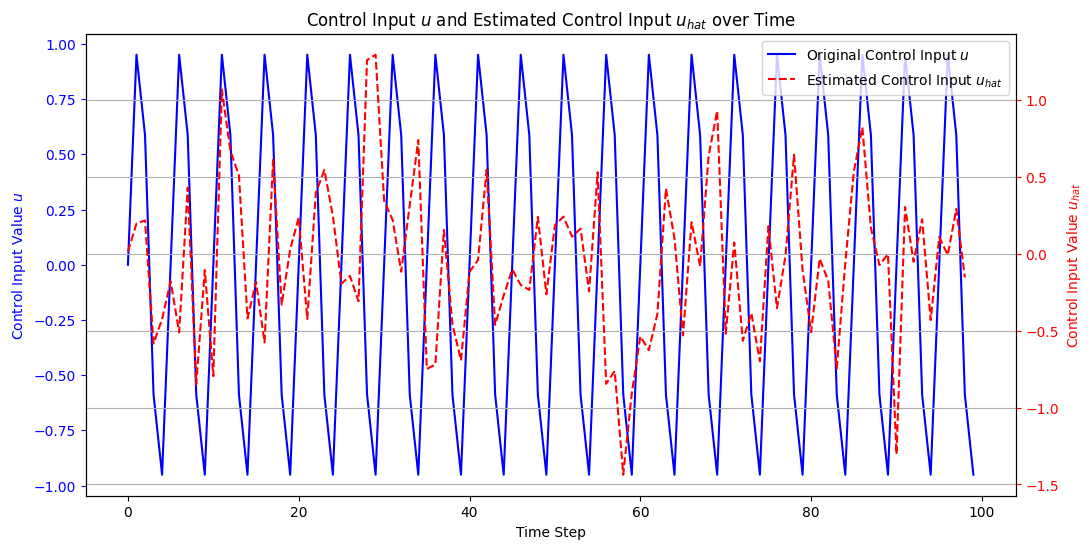

In [ ]:
import matplotlib.pyplot as plt

# Assuming `u` and `u_hat` are numpy arrays of the correct shape
# You can reshape or flatten `u_hat` as required before this step
u_hat_flattened = u_hat.flatten()

# Creating a new figure
plt.figure(figsize=(12, 6))

# Create the primary y-axis for the original control input
ax1 = plt.gca()
ax1.plot(u, 'b-', label='Original Control Input $u$')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Control Input Value $u$', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Control Input $u$ and Estimated Control Input $u_{hat}$ over Time')

# Create a secondary y-axis for the estimated control input if necessary
ax2 = ax1.twinx()
ax2.plot(u_hat_flattened, 'r--', label='Estimated Control Input $u_{hat}$')
ax2.set_ylabel('Control Input Value $u_{hat}$', color='r')
ax2.tick_params('y', colors='r')

# Adding the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.grid(True)
plt.show()

In [ ]:
k=Atil@z-btil
# print(k)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[0] and Estimated x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

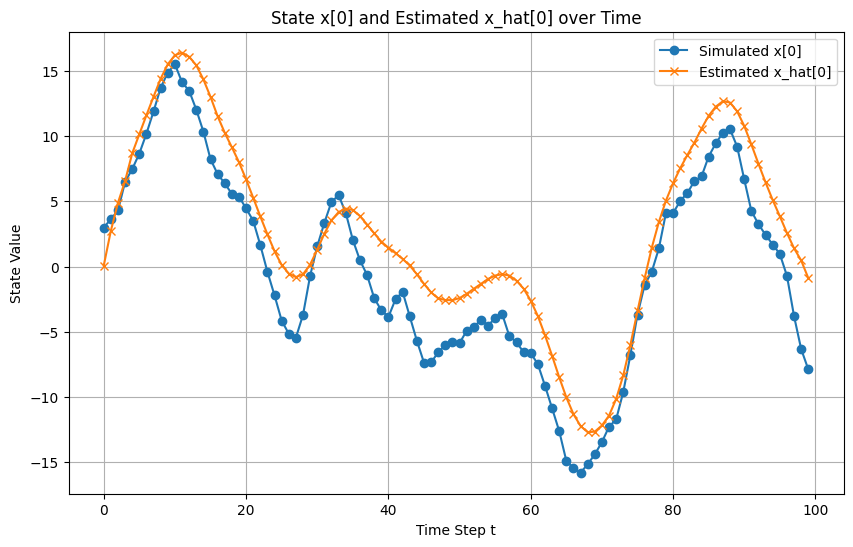

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[1] and Estimated x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

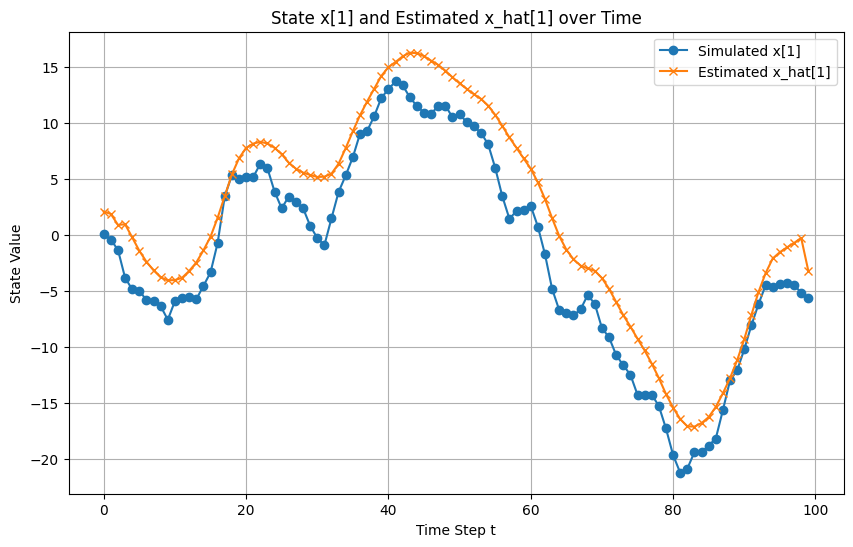

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[2] and Estimated x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

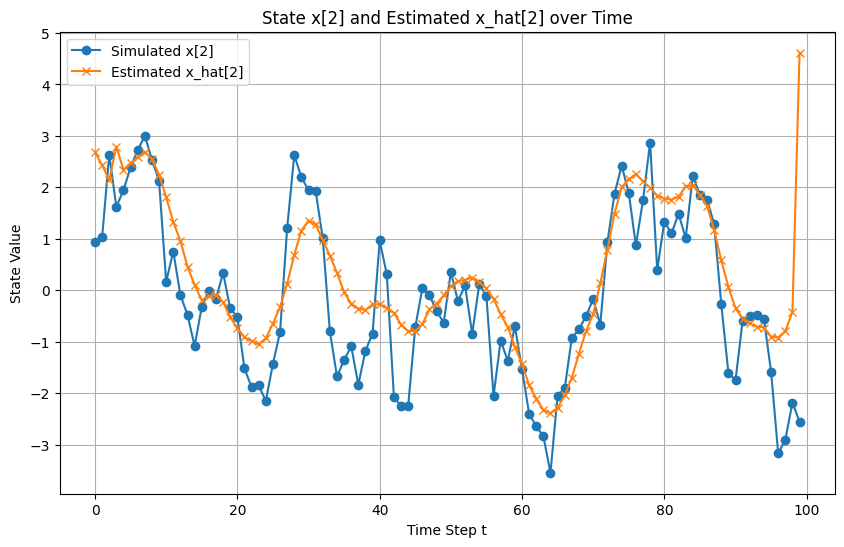

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[3] and Estimated x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

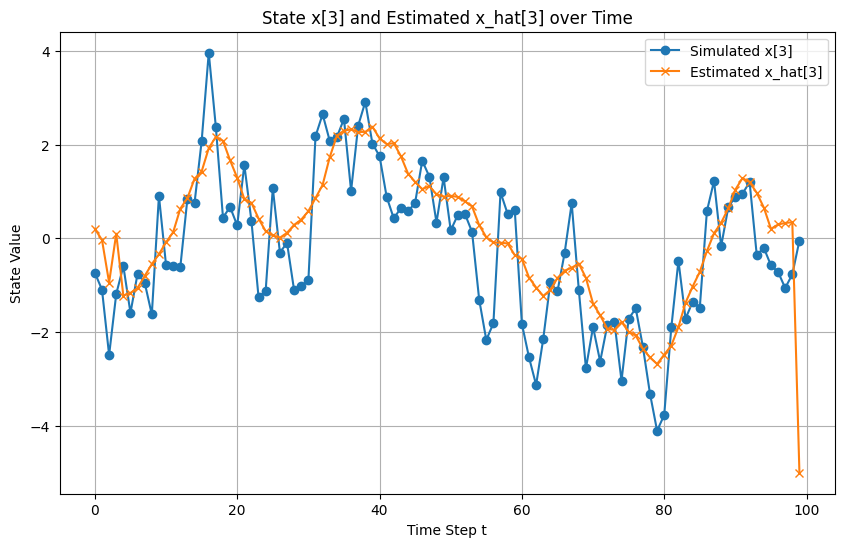

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x and x_hat are loaded or computed already and are numpy arrays
T = len(x_hat)  # Correct to define T based on the length of x_hat
t = np.arange(T)  # Time vector

# Ensure x_hat is a proper numpy array for slicing
x_hat = np.array(x_hat)  # Ensuring it's numpy array
x = np.array(x)  # Ensuring x is also a numpy array

# Loop through each state component for plotting
for i in range(x.shape[1]):  # This assumes x is 2D (time steps, state variables)
    plt.figure(figsize=(10, 6))

    # Plot simulated state (including all states)
    plt.plot(t, x[1:, i], label=f'Simulated x[{i}]', marker='o')

    # Plot estimated state (ensure x_hat matches dimensions)
    plt.plot(t, x_hat[:, i], label=f'Estimated x_hat[{i}]', marker='x')

    plt.title(f'State x[{i}] and Estimated x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('State Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
print(x[-5:])  # Print the last 5 entries of the true state
print(x_hat[-5:])

[[ 0.96133369 -4.37128115 -1.58355068 -0.57655712]
 [-0.71454848 -4.28622896 -3.16870274 -0.71634573]
 [-3.80944667 -4.43521478 -2.90114328 -1.05965624]
 [-6.33199498 -5.19008655 -2.18253347 -0.76852851]
 [-7.88513083 -5.6640876  -2.5539606  -0.0478061 ]]
[[[ 3.85691512]
  [-1.54579565]
  [-0.89978381]
  [ 0.20130873]]

 [[ 2.572663  ]
  [-1.11768341]
  [-0.9165569 ]
  [ 0.29557224]]

 [[ 1.39863637]
  [-0.72235422]
  [-0.79215974]
  [ 0.32805421]]

 [[ 0.46751431]
  [-0.26884644]
  [-0.41904263]
  [ 0.34353351]]

 [[-0.88711843]
  [-3.20237985]
  [ 4.61577745]
  [-4.99856043]]]


<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[0] and Estimated x_hat[0] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

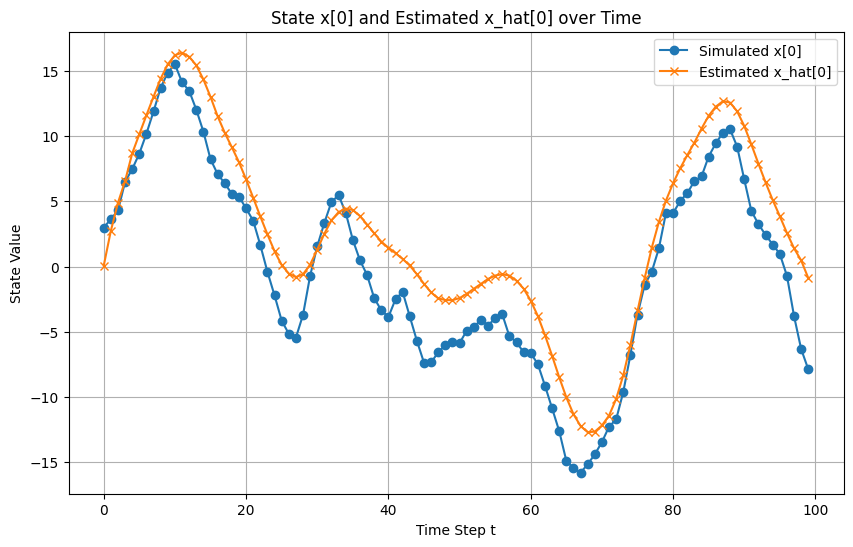

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[1] and Estimated x_hat[1] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

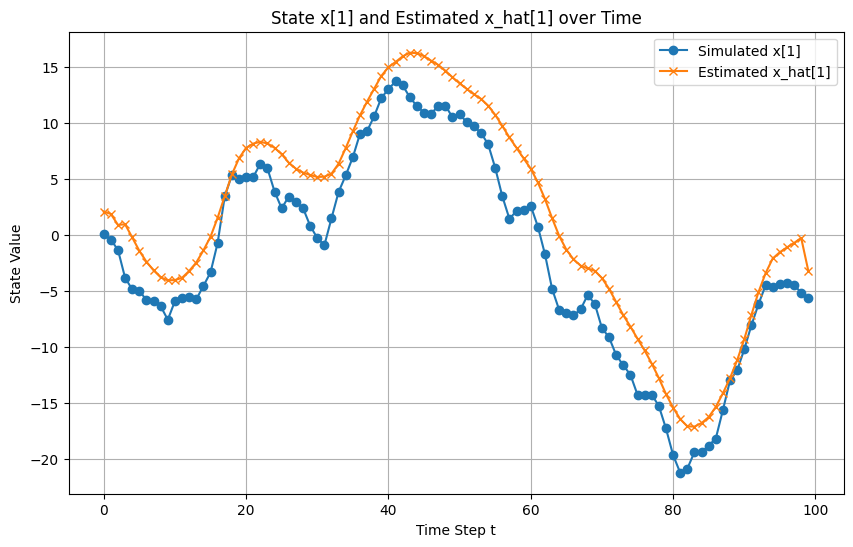

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[2] and Estimated x_hat[2] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

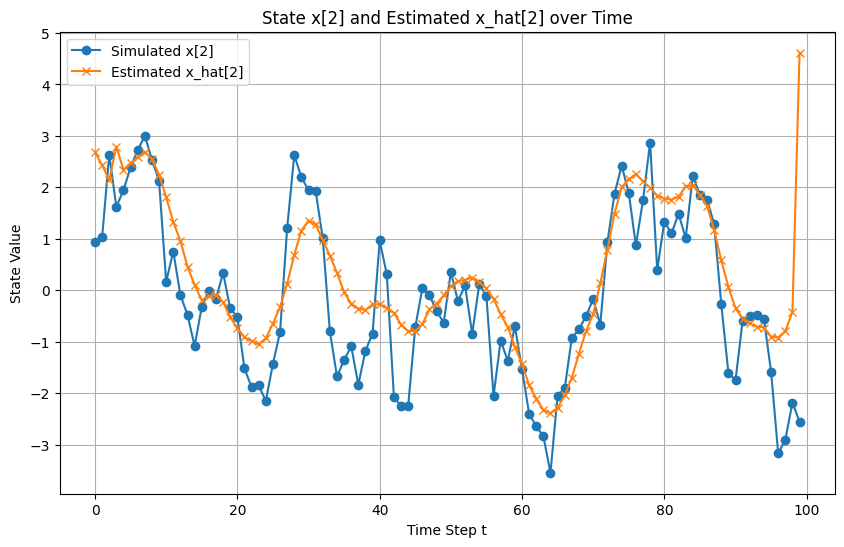

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'State x[3] and Estimated x_hat[3] over Time')

Text(0.5, 0, 'Time Step t')

Text(0, 0.5, 'State Value')

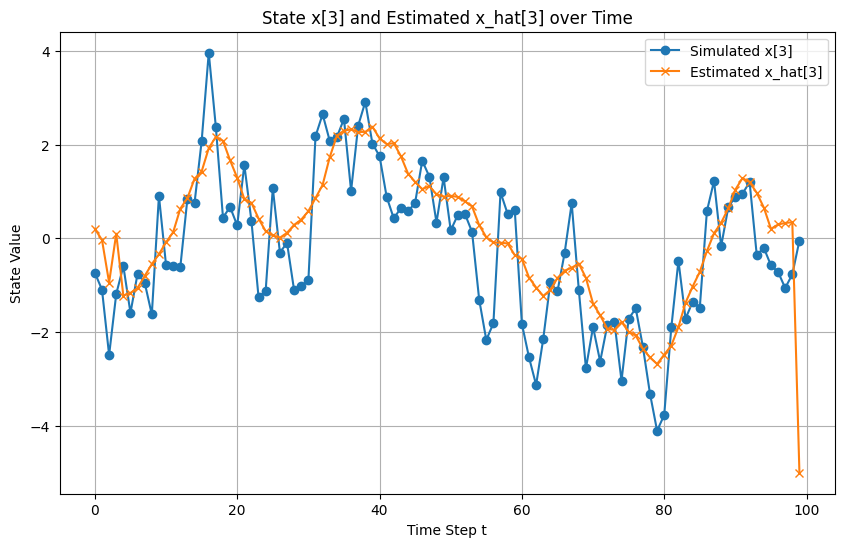

In [ ]:
T = len(x_hat)  # Use the length of x_hat to define the time vector

# Adjust the time vector to match the length of x_hat
t = np.arange(T)

# Assuming x_hat_m is a modified version of x_hat to match naming in your code,
# Ensure it's reshaped or sliced to match dimensions if necessary
x_hat_m = np.squeeze(np.array(x_hat))  # This helps if x_hat is an array of arrays
x=np.array(x)

# Loop through each state component for plotting
for i in range(x.shape[1]):  # Assuming x is 2D and we're iterating over the second dimension
    plt.figure(figsize=(10, 6))

    # Plot simulated state, excluding the initial state from x for plotting
    plt.plot(t, x[1:, i], label=f'Simulated x[{i}]', marker='o')  # Adjust x to exclude its first entry

    # Plot estimated state
    plt.plot(t, x_hat_m[:, i], label=f'Estimated x_hat[{i}]', marker='x')

    plt.title(f'State x[{i}] and Estimated x_hat[{i}] over Time')
    plt.xlabel('Time Step t')
    plt.ylabel('State Value')
    plt.legend()
    plt.grid(True)
    plt.show()

<Figure size 1200x800 with 0 Axes>

Text(0.5, 1.0, 'True and Estimated States Over Time')

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'State Value')

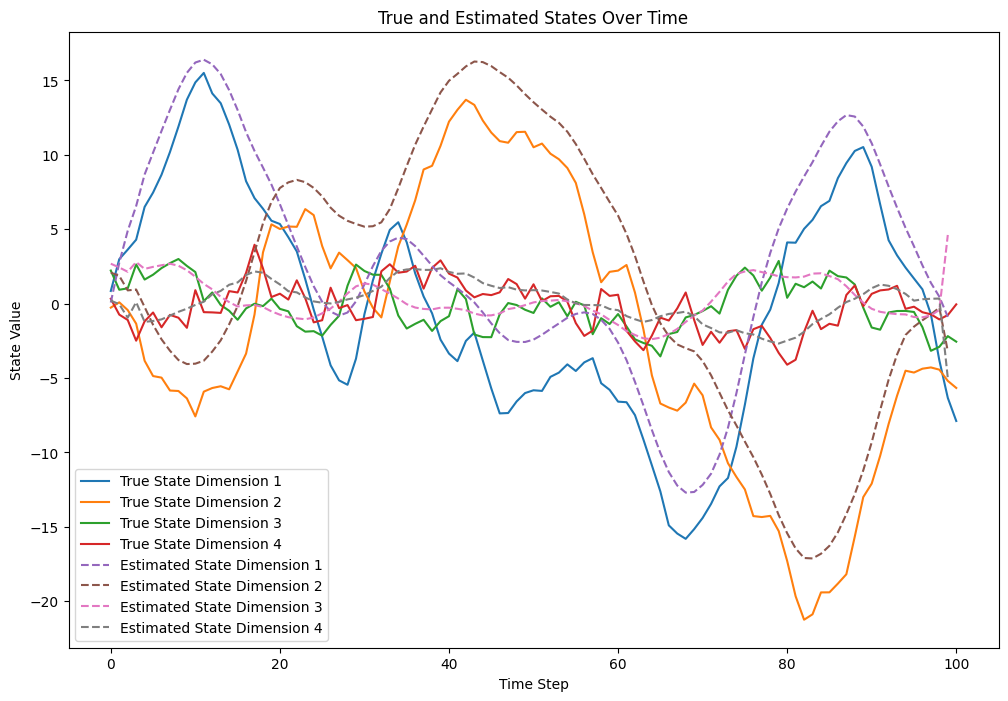

In [ ]:
x_array = np.array(x)  # True states, as a 2D numpy array
x_hat_array = np.array(x_hat)  # Estimated states, as a 2D numpy array

# Adjusting the timestamps to match the length of x_hat
timestamps_x = np.arange(x_array.shape[0])
timestamps_x_hat = np.arange(x_hat_array.shape[0])

plt.figure(figsize=(12, 8))

# Plot each dimension of x
for i in range(x_array.shape[1]):
    plt.plot(timestamps_x, x_array[:, i], label=f'True State Dimension {i+1}')

# Plot each dimension of x_hat with adjusted timestamps
for i in range(x_hat_array.shape[1]):
    plt.plot(timestamps_x_hat, x_hat_array[:, i], '--', label=f'Estimated State Dimension {i+1}')

plt.title('True and Estimated States Over Time')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend(loc='best')
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Comparison of Centered Half Atil @ z - btil Values and Corresponding Half v Values')

Text(0.5, 0, 'Time Steps')

Text(0, 0.5, 'Centered Values')

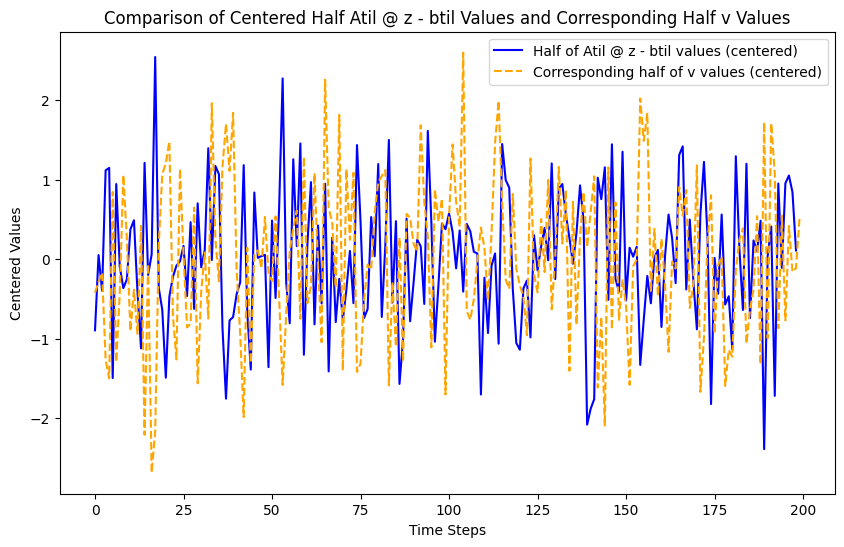

In [ ]:
k = Atil @ z - btil
half_k = k[:len(k) // 2]



half_v = np.array(v[:len(half_k)]).reshape(-1, 1)

# Normalize both datasets to have zero mean
half_k_centered = half_k - np.mean(half_k)
half_v_centered = half_v - np.mean(half_v)

# Now let's plot the centered half u values and corresponding half v values
plt.figure(figsize=(10, 6))
plt.plot(half_k_centered, label='Half of Atil @ z - btil values (centered)', linestyle='-', color='blue')
plt.plot(half_v_centered, label='Corresponding half of v values (centered)', linestyle='--', color='orange')
plt.title('Comparison of Centered Half Atil @ z - btil Values and Corresponding Half v Values')
plt.xlabel('Time Steps')
plt.ylabel('Centered Values')
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, 'Comparison of True and Estimated States Over Time')

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'State Value')

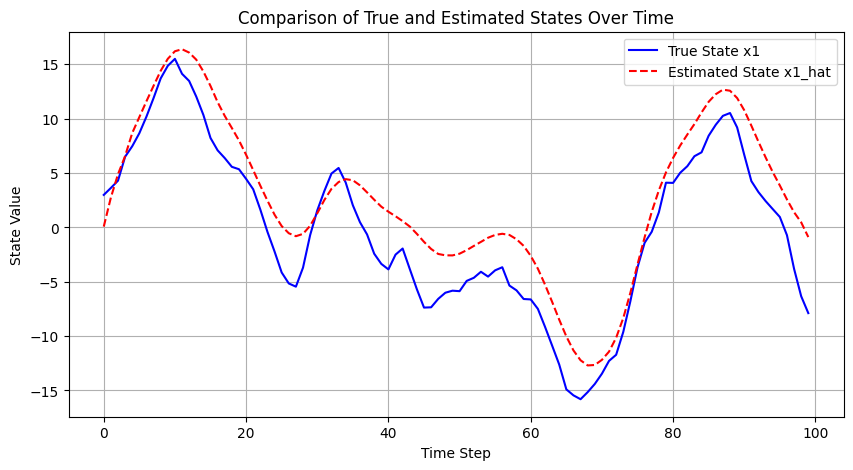

In [ ]:
import matplotlib.pyplot as plt

# Ensure x and x_hat are NumPy arrays
x_array = np.array(x)  # If not already an array, convert it
x_hat = np.array(x_hat)  # Assuming x_hat is already in the proper format from lqe

# Time vector for plotting
time_steps = np.arange(T)  # T should be the length of your simulation

# Plotting the first state variable from both x and x_hat
plt.figure(figsize=(10, 5))  # Set the figure size for better visibility
plt.plot(time_steps, x_array[1:, 0], 'b-', label='True State x1')  # True state
plt.plot(time_steps, x_hat[:, 0], 'r--', label='Estimated State x1_hat')  # Estimated state

plt.title('Comparison of True and Estimated States Over Time')  # Title of the plot
plt.xlabel('Time Step')  # Label for the x-axis
plt.ylabel('State Value')  # Label for the y-axis
plt.legend()  # Add a legend to distinguish the plots
plt.grid(True)  # Add a grid for easier readability
plt.show()  # Display the plot

